![NYPLogo.png](attachment:NYPLogo.png)

# IT3311 Assignment - Task 2: Image Classification

You are required to build an image classification model to predict the product category based on the product image. This analysis aims to be accompaniment to the results of the text classification and the possibilities of using the image classification results together for product category classification.

**Tasks:**

1. **Data Understanding**: Examine the dataset
2. **Data Preparation**: Prepares the data and all necessary preprocessing tasks
3. **Modelling**: Use different text representation and algorithms
4. **Evaluation**: Evaluates results from the algorithms and select the best model

**Done by: Chua ZhengHong Jonathan - 201611S**

# Table of contents
1. [Data Understanding](#understanding)
    * 1.1 [Category](#understandingcategory)
    * 1.2 [Images](#understandingimages)
2. [Data Preparation](#preparation)
    * 2.1 [Resize Images](#resizeimages)
    * 2.2 [Image Thresholding](#imagethresholding)
    * 2.2 [Remove Noise](#removenoise)
    * 2.4 [Morphological Operations](#morphological)
3. [Modelling](#modelling)
    * 3.1 [Data Representations](#datarepresentaion)
        * 3.1.1 [Historgram of Oriented Gradients](#hog)
    * 3.2 [Supervised Learning Classifiers](#supervised)
        * 3.2.1 [Logistic Regression](#logisiticregression)
        * 3.2.2 [KNeighborsClassifier](#knn)
        * 3.2.3 [DecisionTreeClassifier](#decisiontree)
        * 3.2.4 [RandomForestClassifier](#randomforest)
4. [Evaluation](#evaluation)
    * 4.1 [Multiclass Classification](#multiclass)
        * 4.1.1 [Predicting Category using Logistic Regression](#imagelogisticregression)
        * 4.1.2 [Predicting Category via K-Nearest Neighbours](#imagelinearsvc)
        * 4.1.3 [Predicting Category via Decision Tree](#imagelinearsvc)
        * 4.1.4 [Predicting Category via Random Forest](#imagerandomforest)
    * 4.2 [Model selection, Performance Evaluation and Hyperparameter Tuning using GridSearchCV](#gridsearchcv)
    * 4.3 [Performing Predictions](#prediction)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Text and Media Analytics/'

/content/drive/MyDrive/Text and Media Analytics


## Import libraries and download the packages

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
%matplotlib inline
import seaborn as sns

import PIL
import cv2
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
from skimage.feature import hog

from glob import glob

from itertools import cycle

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Read the dataset

Read the csv file.

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head(5)

,item_id,item_name,image_name,description,category
0,1,etude house drawing eye brow ad,1.jpg,READY\n[Etude Eyebrow]\nnote : tuliskan di ket...,Eye
1,2,etude house drawing eyebrow,2.jpg,READY JGN TNYA LAGI YA \n\nKUALITAS BOLEH DI A...,Eye
2,3,etude -new drawing eyebrow,3.jpg,Barang ORI ya..\nHarga jg sudah nett..\n\nOpti...,Eye
3,4,etude house drawing eye brow ad,4.jpg,QTY PM AJA YA :\nATC TIDAK ADA ALASAN APAPUN P...,Eye
4,5,etude house - color my brow,5.jpg,"ETUDE HOUSE - COLOR MY BROW\n\nTAHAN LAMA, ALI...",Eye


Read the images. The images to be read in have the names listed in the dataframe under the image_name column.

In [ ]:
images, image_names = [], []
labels = []

for dir in glob('images'):
    image_files = glob(dir + '/*.jpg')

    for image_file in image_files:
        image = imread(image_file)

        if len(image.shape) == 2: # if a gray-scale image
            image = gray2rgb(image)
           
        #modified to correctly assign the label to the labels list
        
        #first extract the image file name matching that in the csv (eg 1.jpg)
        image_name = re.sub(r'(images\/){1}(.+)', r'\2', image_file)

        #locate the row in the dataframe matching that image name
        image_row = df.loc[df['image_name'] == image_name]
        
        #get the label, which is the category of that image
        if (not image_row['category'].empty):
            
            label = image_row['category']
            
            #check that the image names and their corresponding labels are retrieved and stored in the lists.
            #print(image_name,label.values[0])
            
            #append the image, image name, and label to the lists
            images.append(image)
            image_names.append(image_name)
            labels.append(label.values[0])
        else:
            print("Category of "+image_name+" not found in data.csv.")

Category of 45.jpg not found in data.csv.


I'm printing the file names to see if all the images could be read in, as well as see a list of the images and their respective label. However, I discovered I could not read in one of the images. From modifying the code, I figured out that 45.jpg exists, but could not be found as an item in the csv.

Next I check to see the dataframe to see if the image 45.jpg islisted.

In [ ]:
df.loc[df['image_name'] == '45.jpg'] 

,item_id,item_name,image_name,description,category


image 45.jpg is not listed in the csv file and I chose to ignore it.

In [ ]:
# Display image
def display_img(img,cmap=None):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

I check if the images can be read in and displayed.

In [ ]:
def read_and_display_img(filepath):
    try:
        display_img(imread(filepath))
    except FileNotFoundError:
        print("The image at "+filepath+" could not be found.")

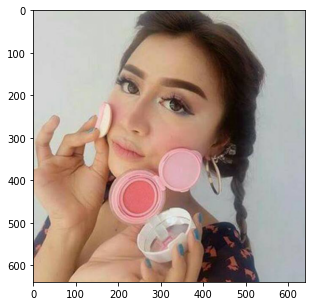

In [ ]:
read_and_display_img('images/45.jpg')

This image exists but I chose not to read it in because it is not reflected in the data.csv.

Reshape the images to 1D to store in dataframe.

In [ ]:
def flatten_image(img):
    x, y, channels = img.shape
    img = img.reshape(x * y * channels)
    return img, x, y, channels

In [ ]:
reshaped_images = []
x_list, y_list, channels_list = [], [], []
for img in images:
    img, x, y, channels = flatten_image(img)
    reshaped_images.append(img)
    x_list.append(x)
    y_list.append(y)
    channels_list.append(channels)

See the shape of a reshaped image to check. This should be converted into 1 Dimension. The core reasoning behind this is for faster storage and retrieval in dataframe.

In [ ]:
reshaped_images[0].shape

(750000,)

Combine my lists into a dataframe.

In [ ]:
images_df = pd.DataFrame(
    {'image_name': image_names,
    'image': reshaped_images,
     'image_x':x_list,
     'image_y':y_list,
     'image_channels':channels_list,
     'category': labels
    })

Check the head of the dataframe.

In [ ]:
images_df.head()

,image_name,image,image_x,image_y,image_channels,category
0,1825.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",500,500,3,Face
1,1892.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640,640,3,Face
2,1868.jpg,"[77, 75, 78, 255, 253, 255, 251, 249, 252, 250...",1024,1024,3,Lip
3,187.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",843,843,3,Eye
4,1869.jpg,"[163, 142, 99, 157, 136, 93, 141, 120, 77, 129...",640,640,3,Lip


The images appear to be different in both x and y dimensions.

Join this dataframe to the original dataframe to form the dataset.

In [ ]:
df = df.merge(images_df, on=['image_name','category'], how='left')

Check that the dataframe was merged correctly.

In [ ]:
df.head(5)

,item_id,item_name,image_name,description,category,image,image_x,image_y,image_channels
0,1,etude house drawing eye brow ad,1.jpg,READY\n[Etude Eyebrow]\nnote : tuliskan di ket...,Eye,"[255, 254, 255, 255, 254, 255, 255, 254, 255, ...",1024.0,1024.0,3.0
1,2,etude house drawing eyebrow,2.jpg,READY JGN TNYA LAGI YA \n\nKUALITAS BOLEH DI A...,Eye,"[223, 111, 151, 227, 110, 152, 233, 110, 154, ...",700.0,700.0,3.0
2,3,etude -new drawing eyebrow,3.jpg,Barang ORI ya..\nHarga jg sudah nett..\n\nOpti...,Eye,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640.0,640.0,3.0
3,4,etude house drawing eye brow ad,4.jpg,QTY PM AJA YA :\nATC TIDAK ADA ALASAN APAPUN P...,Eye,"[255, 254, 255, 255, 254, 255, 255, 254, 255, ...",1024.0,1024.0,3.0
4,5,etude house - color my brow,5.jpg,"ETUDE HOUSE - COLOR MY BROW\n\nTAHAN LAMA, ALI...",Eye,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640.0,640.0,3.0


## 1. Data Understanding<a name='understanding'></a>
Perform the necessary steps and explain the rationale taken here.



In [ ]:
df.head(5)

,item_id,item_name,image_name,description,category,image,image_x,image_y,image_channels
0,1,etude house drawing eye brow ad,1.jpg,READY\n[Etude Eyebrow]\nnote : tuliskan di ket...,Eye,"[255, 254, 255, 255, 254, 255, 255, 254, 255, ...",1024.0,1024.0,3.0
1,2,etude house drawing eyebrow,2.jpg,READY JGN TNYA LAGI YA \n\nKUALITAS BOLEH DI A...,Eye,"[223, 111, 151, 227, 110, 152, 233, 110, 154, ...",700.0,700.0,3.0
2,3,etude -new drawing eyebrow,3.jpg,Barang ORI ya..\nHarga jg sudah nett..\n\nOpti...,Eye,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640.0,640.0,3.0
3,4,etude house drawing eye brow ad,4.jpg,QTY PM AJA YA :\nATC TIDAK ADA ALASAN APAPUN P...,Eye,"[255, 254, 255, 255, 254, 255, 255, 254, 255, ...",1024.0,1024.0,3.0
4,5,etude house - color my brow,5.jpg,"ETUDE HOUSE - COLOR MY BROW\n\nTAHAN LAMA, ALI...",Eye,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640.0,640.0,3.0


From the way I had represented and stored the images in the dataframe, I had uncovered that the images are of different sizes.

image_name is included in the csv file. This is the identifier to map the image to the item_id. Since they have matching numerical values as seen in head, only image_name is needed and item_id can be dropped.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1887 entries, 0 to 1886
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         1887 non-null   int64  
 1   item_name       1887 non-null   object 
 2   image_name      1887 non-null   object 
 3   description     1887 non-null   object 
 4   category        1887 non-null   object 
 5   image           1886 non-null   object 
 6   image_x         1886 non-null   float64
 7   image_y         1886 non-null   float64
 8   image_channels  1886 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 147.4+ KB


This dataset has 5 columns, item_id, item_name, image_name, description, category. There are 1887 documents and no column has null values.<br>
Excluding the item_id (likely the unique identifier and hence not a meaningful feature, all the columns are of String dtype (represented as object in DataFrame).<br>
There appears to be one image missing.

In [ ]:
df.isnull().sum()

item_id           0
item_name         0
image_name        0
description       0
category          0
image             1
image_x           1
image_y           1
image_channels    1
dtype: int64

Check for the missing value.

In [ ]:
df.loc[df['image'].isnull()]

,item_id,item_name,image_name,description,category,image,image_x,image_y,image_channels
44,46,[hot seller] bioaqua liquid foundation bb crea...,46.jpg,Liquid Concealer Foundation BB Cream ini dapat...,Face,NaN,NaN,NaN,NaN


It looks like 46.jpg does not exist.

Drop the row with the missing value. I have decided not to use item_id 46 for modelling.

In [ ]:
df = df.dropna()

Then check once more that there are no longer null values.

In [ ]:
df.isnull().sum()

item_id           0
item_name         0
image_name        0
description       0
category          0
image             0
image_x           0
image_y           0
image_channels    0
dtype: int64

Convert the columns I created from float to int.

In [ ]:
df = df.astype({'image_x': 'int32','image_y': 'int32','image_channels': 'int32'})

In [ ]:
df.head(5)

,item_id,item_name,image_name,description,category,image,image_x,image_y,image_channels
0,1,etude house drawing eye brow ad,1.jpg,READY\n[Etude Eyebrow]\nnote : tuliskan di ket...,Eye,"[255, 254, 255, 255, 254, 255, 255, 254, 255, ...",1024,1024,3
1,2,etude house drawing eyebrow,2.jpg,READY JGN TNYA LAGI YA \n\nKUALITAS BOLEH DI A...,Eye,"[223, 111, 151, 227, 110, 152, 233, 110, 154, ...",700,700,3
2,3,etude -new drawing eyebrow,3.jpg,Barang ORI ya..\nHarga jg sudah nett..\n\nOpti...,Eye,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640,640,3
3,4,etude house drawing eye brow ad,4.jpg,QTY PM AJA YA :\nATC TIDAK ADA ALASAN APAPUN P...,Eye,"[255, 254, 255, 255, 254, 255, 255, 254, 255, ...",1024,1024,3
4,5,etude house - color my brow,5.jpg,"ETUDE HOUSE - COLOR MY BROW\n\nTAHAN LAMA, ALI...",Eye,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640,640,3


### 1.1 Data Understanding - Category<a name='understandingcategory'></a>

As a start I would like to know the possible list of categories. I can do so via getting the value_counts() of the Category column.

In [ ]:
df['category'].value_counts()

Face    930
Lip     501
Eye     455
Name: category, dtype: int64

There are 3 unique values in categories, Face, Lip and Eye.

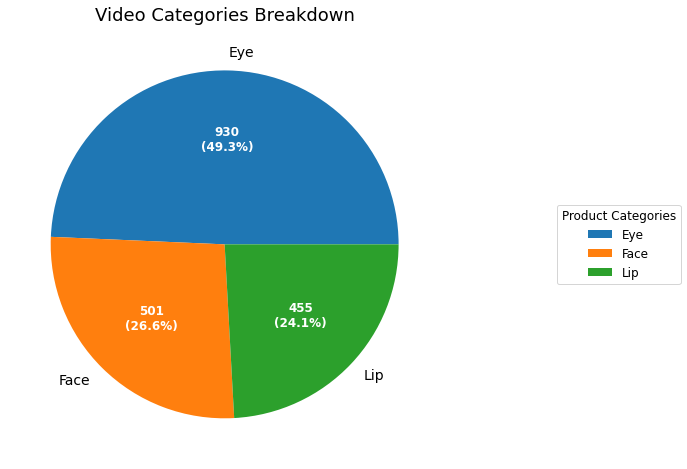

In [ ]:
categories = df['category'].unique()
cat_counts = df['category'].value_counts()
pie_data = np.array(cat_counts)
zipped = zip(cat_counts,categories)

labels = [x for _,x in list(zipped)]
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw=dict(aspect="equal"))

def pie_text(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:d}\n({:.1f}%)".format(absolute, pct)

wedges, texts, autotexts = ax.pie(pie_data, labels=labels, autopct=lambda pct: pie_text(pct, pie_data),
                                  textprops=dict(color="w"))
for i in range(len(texts)):
    texts[i].set_color('k')
    texts[i].set_fontsize(14)

ax.legend(wedges, categories,
          title="Product Categories",
          loc="center left",
          bbox_to_anchor=(1.25, 0, 0.5, 1), fontsize=12)

plt.setp(autotexts, size=12, weight="bold")
plt.setp(plt.gca().get_legend().get_title(), fontsize='12')
ax.set_title("Video Categories Breakdown", fontsize=18)

plt.show() 

As seen in the pie chart above, there is a good mix of each video category and no unbalanced label. I will hence not apply techniques to handle unbalanced data.

### 1.2 Data Understanding - Images<a name='understandingimage'></a>

In [ ]:
df[df['category'] == 'Eye'].head()

,item_id,item_name,image_name,description,category,image,image_x,image_y,image_channels
0,1,etude house drawing eye brow ad,1.jpg,READY\n[Etude Eyebrow]\nnote : tuliskan di ket...,Eye,"[255, 254, 255, 255, 254, 255, 255, 254, 255, ...",1024,1024,3
1,2,etude house drawing eyebrow,2.jpg,READY JGN TNYA LAGI YA \n\nKUALITAS BOLEH DI A...,Eye,"[223, 111, 151, 227, 110, 152, 233, 110, 154, ...",700,700,3
2,3,etude -new drawing eyebrow,3.jpg,Barang ORI ya..\nHarga jg sudah nett..\n\nOpti...,Eye,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640,640,3
3,4,etude house drawing eye brow ad,4.jpg,QTY PM AJA YA :\nATC TIDAK ADA ALASAN APAPUN P...,Eye,"[255, 254, 255, 255, 254, 255, 255, 254, 255, ...",1024,1024,3
4,5,etude house - color my brow,5.jpg,"ETUDE HOUSE - COLOR MY BROW\n\nTAHAN LAMA, ALI...",Eye,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640,640,3


When looking at the dataframe, I check for the first image of each category (by their image_name, which is arranged in numerical order). I use this to identify the images I want to display next. Also I discovered that the images have different sizes (x and y dimensions).

In [ ]:
df[df['category'] == 'Face'].head()

,item_id,item_name,image_name,description,category,image,image_x,image_y,image_channels
7,8,etude house secret beam powder pact,8.jpg,Volume: 16g | Infused with Secret Pearl Powder...,Face,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",500,500,3
8,9,skinfood rice shimmer powder,9.jpg,Skinfood Rice Shimmer Powder New Packaging\n\n...,Face,"[239, 223, 224, 241, 225, 226, 243, 227, 228, ...",524,524,3
9,10,[share in tube ] maybelline fit me matte + por...,10.jpg,Stock in Shade :\nClassic Ivory (120)\nNude Be...,Face,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640,640,3
11,12,clear smooth pressed powder maybelline kemasan...,12.jpg,Clear smooth Pressed powder MAYBELLINE \nWarna...,Face,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",640,640,3
14,15,etude house secret beam pact,15.jpg,Secret beam pact\n#1.light beige\n#2.natural b...,Face,"[21, 23, 20, 21, 23, 20, 21, 23, 20, 21, 23, 2...",640,640,3


In [ ]:
df[df['category'] == 'Lip'].head()

,item_id,item_name,image_name,description,category,image,image_x,image_y,image_channels
12,13,etude house - dear darling water gel tint,13.jpg,MOHON DIBACA DESKRIPSI SEBELUM ORDER\nÃ°ÂÂÂ...,Lip,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",1000,1000,3
15,16,etude house- dear darling water gel tint,16.jpg,Keluaran Terbaru Dear Darling Tint\n\nTekstur ...,Lip,"[245, 245, 255, 245, 245, 255, 245, 245, 255, ...",1024,1024,3
20,21,etude house fresh cherry tint,21.jpg,Waterproof liptint\nTidak berbekas di gelas \n...,Lip,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",640,640,3
21,22,etude house dear darling tint,22.jpg,Etude House - Dear Darling TintThis is famous ...,Lip,"[240, 240, 240, 240, 240, 240, 240, 240, 240, ...",640,640,3
26,27,etude house dear darling water gel tint - lipt...,27.jpg,ETUDE HOUSE Dear Darling Water Gel Tint - Lipt...,Lip,"[135, 133, 136, 135, 133, 136, 135, 133, 136, ...",640,640,3


In [ ]:
df.describe()

,item_id,image_x,image_y,image_channels
count,1886.000000,1886.000000,1886.000000,1886.0
mean,999.485154,666.112407,666.287381,3.0
std,577.611540,162.435750,162.271558,0.0
min,1.000000,100.000000,100.000000,3.0
25%,498.250000,640.000000,640.000000,3.0
50%,998.500000,640.000000,640.000000,3.0
75%,1500.750000,700.000000,700.000000,3.0
max,2000.000000,1024.000000,1024.000000,3.0


Describe reveals that the smallest x is 100 and the smallest y is 100. And the largest x and y is 1024. Looking at the first few items from earlier, the x and y appear to be the same (meaning the images are all square shaped).

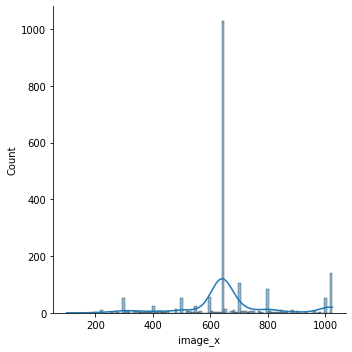

In [ ]:
sns.displot(data=df, x="image_x", kde=True)

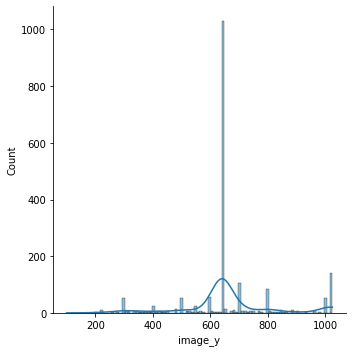

In [ ]:
sns.displot(data=df, x="image_y", kde=True)

The most common image size is 640x640. The x and y dimensions have the same distribution so I conclude that the images are all square shaped (same x and y dimensions). 

#### Images smaller than 640x640

In [ ]:
df[df['image_x'] < 640].shape

(341, 9)

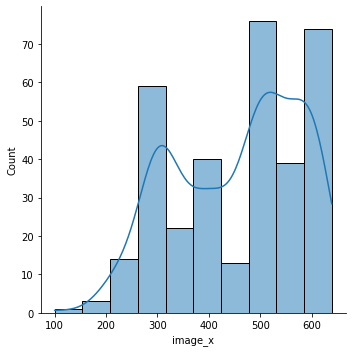

In [ ]:
sns.displot(data=df[df['image_x'] < 640], x="image_x", kde=True)

There are 341 images below the common image size of 640 by 640. The distribution for this small image sizes is right-skewed. It seems that there are very few images below the 200x200 size. I will plot for images below the size 320x320 (half the common size) to take a closer look.

In [ ]:
df[df['image_x'] < 320].shape

(77, 9)

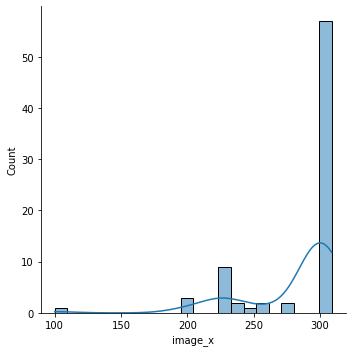

In [ ]:
sns.displot(data=df[df['image_x'] < 320], x="image_x", kde=True)

There are 77 images below the size of 320x320. From the distribtion plot, there appears to be outliers at the size of 200x200 and below.

In [ ]:
df[df['image_x'] == 300].shape

(51, 9)

51 (2.7%) of the 1886 images are of the size 300x300. It could be wise to resize the images to at least 300x300 to retain information in this subset. However, at the same time, most of the images are at 640x640 so those images when reduced in size would lose information if reduced to a smaller size anyway.

In [ ]:
df[df['image_x'] <= 200].shape

(4, 9)

In [ ]:
df[df['image_x'] <= 200]

,item_id,item_name,image_name,description,category,image,image_x,image_y,image_channels
1243,1319,original etude dear darling water tint,1319.jpg,size 10gr\nLiptint baru dari Etude dengan teks...,Lip,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",200,200,3
1323,1401,maybelline refill clear smooth all in one,1401.jpg,What it is\nClear Smooth All in one Two Way Ca...,Face,"[254, 255, 237, 254, 255, 237, 254, 255, 237, ...",200,200,3
1463,1551,etude house dear darling gel tint new,1551.jpg,ETUDE HOUSE Dear Darling Gel Tint NEW,Lip,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",100,100,3
1530,1623,etude drawing eyebrow - pensil alis etude,1623.jpg,ETUDE DRAWING EYEBROW ready\n\nDEEP BROWN AJA ...,Eye,"[236, 230, 232, 236, 230, 232, 236, 230, 232, ...",200,200,3


There are only 1 image in the size of 100x100 and below. Hence ths image is the outlier that can be removed. The reason for removing these really small images is to prevent image information loss from resizing the images. Basically if I chose a size above 100x100 when resizing images, these images would be enlarged.<br> On the other hand if I resized every image to 100x100, most of the images would dramatically lose their information from being resized to a really small size. Since there are only 4 images of size 200x200 and below, it is not a good idea to make the image sizes too small as the majority of the images would lose their information.

In [ ]:
df = df[df['image_x'] > 100]

#### Images in the common size of 640x640 and above

In [ ]:
df[df['image_x'] >= 640].shape

(1545, 9)

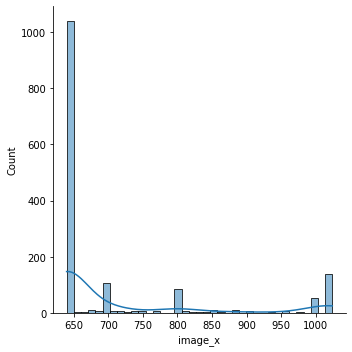

In [ ]:
sns.displot(data=df[df['image_x'] >= 640], x="image_x", kde=True)

All of the 1545 images in the common size of 640x640 and above should be kept because they can be resized (made smaller) to fit into the model.

In [ ]:
df[df['image_x'] == 1024].shape

(136, 9)

There are 136 images (out of 1886) in the largest size of 1024x1024, further cementing that these images above the size of 640x640 should be kept.

In [ ]:
df.shape

(1885, 9)

Dropping the smallest image, I now have 1885 images as use for the input for modelling.

#### Visualizing the image data

Next I retrieve and reshape the images then store in a dictionary as the input for the model. (I couldn't store these in the original shape in the dataframe because it slowed down the dataframe processing)

Define an image to retore the images from 1D to 3D (x, y, color channels).

In [ ]:
def unflatten_image(img, x, y, channels):
    img = img.reshape(x, y, channels)
    return img

Iterate over DataFrame rows and retrieve and store the index and images into dictionary.

In [ ]:
images_dict = {}
for i, row in df.iterrows():
    img = unflatten_image(row["image"], row["image_x"], row["image_y"], row["image_channels"])
    images_dict[i] = img

Next I take a look at the first image to see what it looks like.

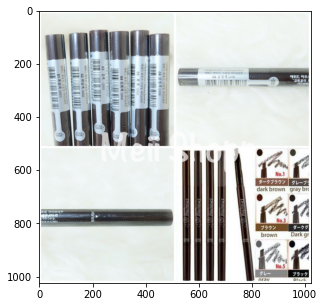

In [ ]:
display_img(images_dict[0])

Name of the item.

In [ ]:
df['item_name'][0]

'etude house drawing eye brow ad'

Item description.

In [ ]:
df['description'][0]

'READY\n[Etude Eyebrow]\nnote : tuliskan di keterangan warna item yang dipilih\n\nPensil alis bertekstur lembut hadir dengan bermacam varian warna agar sesuai dengan warna kulit & rambut, memberikan hasil natural & rapi\n\nDrawing Eye Brow AD 01 dark brown\nDrawing Eye Brow AD 02 grey brown \nDrawing Eye Brow AD 03 brown\nDrawing Eye Brow AD 04 dark grey \nDrawing Eye Brow AD 05 grey\nDrawing Eye Brow AD 06 black\n\napabila tdk tersedia dikirim yg ada , kecuali tdk ada = cancel\n\nno komplain !!!'

In [ ]:
images_dict[0].shape

(1024, 1024, 3)

Here is how some of the images look like. I display one from each category of Eye, Face and Lip.

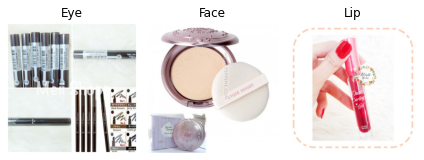

In [ ]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

# plot first image of each category: Eye, Face, Lip
imageslist = {df['category'][0]: images_dict[0], df['category'][7]: images_dict[7], df['category'][12]: images_dict[12]}

display_multiple_img(imageslist, 1, 3)

## 2. Data Preparation<a name='preparation'></a>
Perform the necessary steps and explain the rationale taken here.



### 2.1 Resize Images<a name='resizeimages'></a>

Resized images to 160 by 160. This standardizes the image size for the predictive models to ingest. As discovered from importing the images, they are varied in size.

In [ ]:
size = (100, 100)

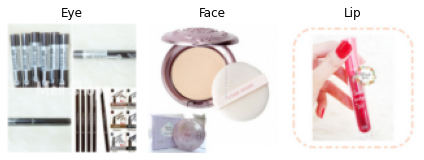

In [ ]:
images_dict = {k: resize( v, size ) for k, v in images_dict.items()}
    
# plot first image of each category: Eye, Face, Lip
imageslist = {df['category'][0]: images_dict[0], df['category'][7]: images_dict[7], df['category'][12]: images_dict[12]}

display_multiple_img(imageslist, 1, 3)

Re-convert the image values to the 0-255 range. (Rounded to nearest whole number)

In [ ]:
images_dict = {k: np.round( ( v * 255 ) ).astype( np.uint8 ) for k, v in images_dict.items()}

See the shape of an image to check that the images have been resized correctly.

In [ ]:
images_dict[0].shape

(100, 100, 3)

View the first image to see that the values have been correctly converted.

In [ ]:
images_dict[0]

array([[[252, 253, 252],
        [249, 250, 248],
        [249, 250, 248],
        ...,
        [250, 251, 250],
        [250, 252, 251],
        [253, 253, 253]],

       [[249, 250, 248],
        [238, 240, 234],
        [238, 240, 233],
        ...,
        [239, 244, 240],
        [241, 246, 244],
        [250, 251, 251]],

       [[249, 249, 248],
        [237, 240, 233],
        [236, 239, 232],
        ...,
        [239, 244, 240],
        [240, 245, 241],
        [250, 251, 250]],

       ...,

       [[249, 251, 250],
        [238, 244, 242],
        [239, 245, 245],
        ...,
        [ 72,  71,  69],
        [ 84,  83,  82],
        [197, 196, 196]],

       [[250, 251, 251],
        [241, 246, 246],
        [241, 247, 247],
        ...,
        [190, 187, 178],
        [217, 215, 211],
        [245, 245, 244]],

       [[253, 253, 253],
        [250, 252, 252],
        [250, 252, 252],
        ...,
        [233, 232, 228],
        [247, 247, 245],
        [253, 253, 253]]

Display that same first image to see if the converted values results in the same picture.

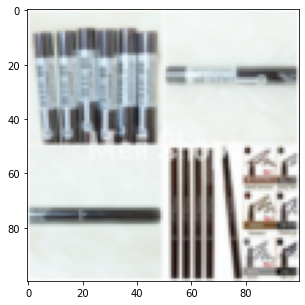

In [ ]:
display_img(images_dict[0])

#### Detect and Remove Duplicate Images

Now that the images have been resized, check if there are duplicates and remove them.

In [ ]:
keys = []
values = []
for key, value in images_dict.items():
    keys.append(key)
    img, x, y, channels = flatten_image(value)
    values.append(img)

In [ ]:
data = {'index': keys, 'resized_images': values}
resized_images_df =  pd.DataFrame.from_dict(data)

In [ ]:
resized_images_df

,index,resized_images
0,0,"[252, 253, 252, 249, 250, 248, 249, 250, 248, ..."
1,1,"[238, 106, 153, 237, 109, 154, 231, 111, 156, ..."
2,2,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
3,3,"[252, 253, 252, 249, 250, 248, 249, 250, 248, ..."
4,4,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
...,...,...
1880,1882,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1881,1883,"[254, 254, 254, 254, 254, 254, 254, 254, 254, ..."
1882,1884,"[187, 215, 237, 188, 216, 238, 184, 214, 235, ..."
1883,1885,"[252, 254, 251, 252, 254, 251, 252, 254, 251, ..."


Get the images that are duplicates. (Except the first occuring image that has duplicate, that way the unique first occuring images are not removed too).

In [ ]:
dupes = resized_images_df[resized_images_df['resized_images'].apply(tuple).duplicated(keep='first')]

In [ ]:
len(dupes)

261

There are 261 duplicate images.

This dataframe contains the indexes for which the rows with duplicate images in the original dataframe can be removed.

In [ ]:
dupes

,index,resized_images
49,50,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
183,184,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
227,228,"[255, 255, 255, 255, 255, 255, 255, 254, 254, ..."
262,263,"[112, 86, 62, 91, 68, 47, 68, 49, 26, 102, 82,..."
288,289,"[252, 253, 252, 249, 250, 248, 249, 250, 248, ..."
...,...,...
1876,1878,"[254, 254, 254, 254, 254, 254, 254, 254, 254, ..."
1877,1879,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1881,1883,"[254, 254, 254, 254, 254, 254, 254, 254, 254, ..."
1882,1884,"[187, 215, 237, 188, 216, 238, 184, 214, 235, ..."


Get the index values to drop in the original dataframe.

In [ ]:
dupe_rows = df.loc[dupes['index']]

In [ ]:
dupe_rows.index

Int64Index([  50,  184,  228,  263,  289,  291,  295,  303,  307,  312,
            ...
            1859, 1864, 1866, 1867, 1877, 1878, 1879, 1883, 1884, 1885],
           dtype='int64', length=261)

Drop the rows according to this index.

In [ ]:
df = df.drop(dupe_rows.index, axis=0)

In [ ]:
df.shape

(1624, 9)

The 261 rows with duplicate images are now removed from the original dataframe. Hence there are 1885 - 261 = 1624 rows.

Get the dictionary containing only the keys of the non-duplicate images.

In [ ]:
images_dict = {key: images_dict[key] for key in df.index}

In [ ]:
len(images_dict)

1624

### 2.2 Image Thresholding<a name='imagethresholding'></a>

Convert images to grayscale.

In [ ]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title], 'gray')
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

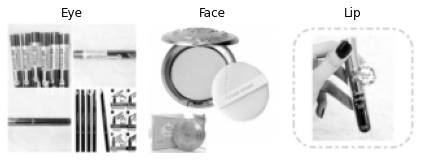

In [ ]:
images_dict = {k: cv2.cvtColor(v, cv2.COLOR_BGR2GRAY) for k, v in images_dict.items()}

# plot first image of each category: Eye, Face, Lip
imageslist = {df['category'][0]: images_dict[0], df['category'][7]: images_dict[7], df['category'][12]: images_dict[12]}

display_multiple_img(imageslist, 1, 3)

### 2.3 Remove Noise<a name='removenoise'></a>

Done to prevent unwanted noise from being identified as feature edges by edge detection.

#### Image Denoising via Average Blurring

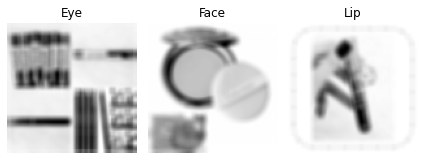

In [ ]:
# Average Blur using kernel of 5x5 size
images_dict = {k: cv2.blur( v, ksize=(5,5) ) for k, v in images_dict.items()}

# plot first image of each category: Eye, Face, Lip
imageslist = {df['category'][0]: images_dict[0], df['category'][7]: images_dict[7], df['category'][12]: images_dict[12]}

display_multiple_img(imageslist, 1, 3)

### 2.4 Morphological Operations<a name='morphological'></a>

#### Gradients

Laplacian edge detector used to identify the features for use later in modelling.

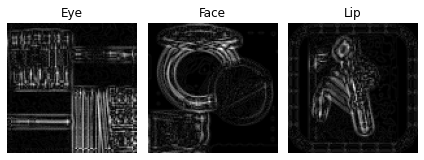

In [ ]:
# Apply Laplacian edge detection
laplacian_images_dict = {k: cv2.convertScaleAbs(cv2.Laplacian(v,cv2.CV_64F)) for k, v in images_dict.items()}

# plot first image of each category: Eye, Face, Lip
imageslist = {df['category'][0]: laplacian_images_dict[0], df['category'][7]: laplacian_images_dict[7], df['category'][12]: laplacian_images_dict[12]}

display_multiple_img(imageslist, 1, 3)

In general, the Laplacian edge detection kept the basic shapes of the objects in the images as the edges. This eliminates the context of color and texture as image features, but the core shapes are good enough because the classifier is supposed to differentiate between lip, eye and face products in general, which are largely differentiated by their overall shape. Using this retains the context of the surrounding objects which may or may not be relevant to the product category in question.

## 3 Modelling<a name='modelling'></a>
Perform the necessary steps and explain the rationale taken here.



### 3.1 Data Representations<a name='datarepresentation'></a>

Get the Preprocessed images.

In [ ]:
lap_imgs = laplacian_images_dict

#### 3.1.1 Histogram of Oriented Gradients<a name='hog'></a>

Applied to extract the feature vector (the data representation) of HOG (the feature descriptor) of the images. This will be used as input for the model to learn.

In [ ]:
hog_X, hog_images = [], []
ppc = 16
for index, image in lap_imgs.items():
    if len(image.shape) == 2: # if a gray-scale image
        image = gray2rgb(image)
        
    #extracts fd, the feature vector, hog_image, the hisogram of oriented gradients image
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc), 
                       cells_per_block=(4, 4), block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_X.append(fd)

Here is what the same images from the previous pre-processing steps look like after applying HOG.

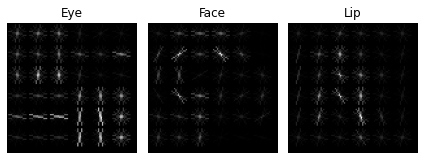

In [ ]:
# plot first image of each category: Eye, Face, Lip
hoglist = {df['category'][0]: hog_images[0], df['category'][7]: hog_images[7], df['category'][12]: hog_images[12]}

display_multiple_img(hoglist, 1, 3)

These are some examples of the features extracted out from the images for use in classification. As seen in the three pictures, the information retained looks like summaries of the overall shape of the objects, along with curves and edges reflected in the directions of the lines. The main difference between this and the laplacian images is the difficulty to see what the HOG vectors repsent visually (can no longer see the hand in the lip image for example).

In [ ]:
# HOG descriptor and label for each image
hog_X = np.array(hog_X)
y = df['category']
indices = np.arange(len(hog_X))

y = np.array(y)

#split into 90% Training, 10% Test
# Test will be used for the final evaluation.
# The 90% Training will later be split into train-validation for the training stage.
X_learn, X_test, y_learn, y_test = train_test_split(hog_X, y, test_size=0.1, random_state=1, stratify=y)

### 3.2 Supervised Learning Classifiers<a name='supervised'></a> 

I decided to try out various supervised learning classifiers because the images have been given labels (the categories). All of the following classifiers can be applied to multiclass classification.

#### 3.2.1 Logistic Regression<a name='logisticregression'></a> 

In [ ]:
lr = LogisticRegression(max_iter=5000, random_state=1, solver='lbfgs', multi_class='multinomial', n_jobs=-1)

Include one classifier that works on linear model for comparison. Logistic Regression that has uses a logistic sigmoid function to predict a value score for binary classification. Scikit learn provides a version of the classifier for more than two classes via their multi_class option.

#### 3.2.2 KNeighborsClassifier<a name='knn'></a> 

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)

Included K-Nearest Neighbours for generalising to distinct seperation of the 3 labels based on their similarity. Could possibly work well compared to learning from relying on an underlying relationship model such as polynomial or linear equations.

#### 3.2.3 DecisionTreeClassifier<a name='decisiontree'></a> 

In [ ]:
dtc = tree.DecisionTreeClassifier()

Added as base to compare with Random Forest. Makes explainable splits into decision rule based branches. Hence it could help show what makes each label differ from each other.

#### 3.2.4 RandomForestClassifier<a name='randomforest'></a> 

In [ ]:
rfc = RandomForestClassifier(random_state = 1, n_jobs=-1) 

Decided to go with Random Forest since an ensemble learning technique would likely give better results. Needed to compare with a Decision Tree classifier because random forest is a mix of decision trees. Is is likely that Random Forest works better compared to basic Decision Tree.

## 4 Evaluation<a name='evaluation'></a> 
Perform the necessary steps and explain the rationale taken here.



### 4.1 Multi-class Classification<a name='multiclass'></a>

I will be doing multi-class classification. This means that the label will be predicted to be one of the given categories, which are Face, Eye, Lip.

In [ ]:
#split into 80% Training, 10% Validation, 10% Test
# Test will be used for the final evaluation.
X_train, X_valid, y_train, y_valid = train_test_split(X_learn, y_learn, test_size=0.18, random_state=1, stratify=y_learn)

#### 4.1.1 Predicting Category via Logistic Regression<a name='imagelogisticregression'></a>

In [ ]:
%time lr.fit(X_train, y_train)

CPU times: user 20.8 ms, sys: 5.96 ms, total: 26.8 ms
Wall time: 1.66 s


LogisticRegression(max_iter=5000, multi_class='multinomial', n_jobs=-1,
                   random_state=1)

In [ ]:
y_pred = lr.predict(X_valid)
print("classification report:")
print(classification_report(y_valid, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.66      0.55      0.60        67
        Face       0.70      0.79      0.74       131
         Lip       0.55      0.49      0.52        65

    accuracy                           0.66       263
   macro avg       0.64      0.61      0.62       263
weighted avg       0.65      0.66      0.65       263



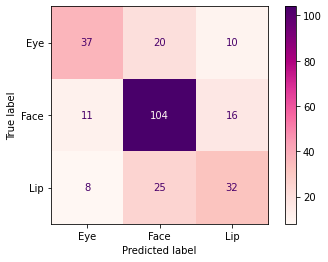

In [ ]:
matrix = confusion_matrix(y_valid, y_pred, labels = lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= lr.classes_)
disp.plot(cmap='RdPu')

Using the resized images with HOG applied, this model works best on Face followed by Eye then Lip. 

##### Receiver Operating Characteristic (ROC) Curve

In [ ]:
y_score = lr.predict_proba(X_valid)

In [ ]:
n_classes = len(np.unique(y))
target_names = np.unique(y)

In [ ]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_valid = label_binarizer.transform(y_valid)
y_onehot_valid.shape

(263, 3)

In [ ]:
def plot_roc_curve(fpr, tpr, name, color, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=name, color=color)
    #plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.title(name)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

In [ ]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_valid[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

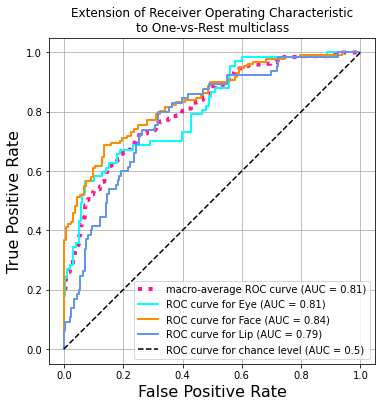

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    plot_roc_curve(
        fpr[class_id],
        tpr[class_id],
        name=f"ROC curve for {target_names[class_id]} (AUC = {roc_auc[class_id]:.2f})",
        color=color
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

Plotting ROC Curves reveal the curves are close to each other and the macro-average, with Lip deviating the most, falling below the rest of the curves.

#### 4.1.2 Predicting Category via K-Nearest Neighbours<a name='imageknn'></a>

In [ ]:
%time knn.fit(X_train, y_train)

CPU times: user 2.49 ms, sys: 0 ns, total: 2.49 ms
Wall time: 2.5 ms


KNeighborsClassifier(n_jobs=-1)

In [ ]:
y_pred = knn.predict(X_valid)
print("classification report:")
print(classification_report(y_valid, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.72      0.49      0.58        67
        Face       0.71      0.79      0.75       131
         Lip       0.48      0.52      0.50        65

    accuracy                           0.65       263
   macro avg       0.64      0.60      0.61       263
weighted avg       0.66      0.65      0.65       263



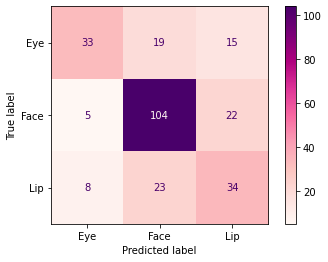

In [ ]:
matrix = confusion_matrix(y_valid, y_pred, labels = knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= knn.classes_)
disp.plot(cmap='RdPu')

Lead to dramatic drop in recall for Eye but rise in recall for Face. Seems to work better for correctly predicting a product belongs to Face category.

#### 4.1.3 Predicting Category via Decision Tree<a name='imagedecisiontree'></a>

In [ ]:
dtc = tree.DecisionTreeClassifier()

In [ ]:
%time dtc.fit(X_train, y_train)

CPU times: user 1.33 s, sys: 882 µs, total: 1.33 s
Wall time: 1.34 s


DecisionTreeClassifier()

In [ ]:
y_pred = dtc.predict(X_valid)
print("classification report:")
print(classification_report(y_valid, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.43      0.51      0.47        67
        Face       0.64      0.61      0.62       131
         Lip       0.42      0.38      0.40        65

    accuracy                           0.53       263
   macro avg       0.50      0.50      0.50       263
weighted avg       0.53      0.53      0.53       263



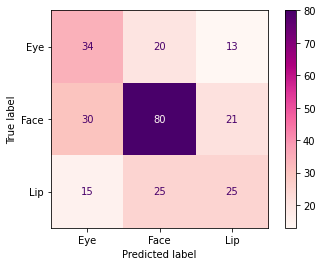

In [ ]:
matrix = confusion_matrix(y_valid, y_pred, labels = dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= dtc.classes_)
disp.plot(cmap='RdPu')

Decision Tree Classifier with default parameters doesn't work well compared to the previous classifiers.

#### 4.1.4 Predicting Category via Random Forest<a name='imagerandomforest'></a>

In [ ]:
%time rfc.fit(X_train, y_train)

CPU times: user 2.65 s, sys: 21.5 ms, total: 2.67 s
Wall time: 1.44 s


RandomForestClassifier(n_jobs=-1, random_state=1)

In [ ]:
y_pred = rfc.predict(X_valid)
print("classification report:")
print(classification_report(y_valid, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.76      0.57      0.65        67
        Face       0.66      0.95      0.78       131
         Lip       0.83      0.29      0.43        65

    accuracy                           0.69       263
   macro avg       0.75      0.60      0.62       263
weighted avg       0.73      0.69      0.66       263



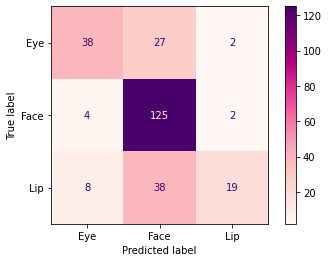

In [ ]:
matrix = confusion_matrix(y_valid, y_pred, labels = rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= rfc.classes_)
disp.plot(cmap='RdPu')

Lead to dramatic drop in recall for Lip. However, recall rose for Face.

### 4.2 Model selection, Performance Evaluation and Hyperparameter Tuning using Pipeline along with GridSearch<a name='gridsearchcv'></a>

From the previous results, it seems that Logistic Regression works better (overall 57 and above recall for the 3 classes)  so I will use this. Now I will attempt hyperparameter tuning to find the optimal hyperparamers for this model.

In [ ]:
lr = LogisticRegression(max_iter=5000, random_state=1, solver='lbfgs', multi_class='multinomial', n_jobs=-1, verbose=3)

pipe = Pipeline(steps=[('estimator', lr)])

params_grid =   {
                'estimator__C': [0.03, 0.1, 0.3, 1, 3]
                }

scoring = ['f1_weighted']

Use 5-fold cross validation to match the ratio of training-validation split of 80-20.

In [ ]:
gs_clf = GridSearchCV(pipe, params_grid, scoring=scoring, refit='f1_weighted', cv=5, n_jobs=-1, verbose=3)

In [ ]:
%time gs_clf = gs_clf.fit(X_learn, y_learn)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


CPU times: user 184 ms, sys: 25.8 ms, total: 210 ms
Wall time: 14.6 s


Show the best parameters.

In [ ]:
print("Grid Search")
print("The best f1-weighted score is: "+ str(gs_clf.best_score_))

for param_name in sorted(params_grid.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

Grid Search
The best f1-weighted score is: 0.661454778935225
estimator__C: 1


### 4.3 Performing Predictions<a name='prediction'></a>

Finally, evaluate this model using the test set.

In [ ]:
y_pred = gs_clf.predict(X_test)
print("classification report:")
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

         Eye       0.78      0.61      0.68        41
        Face       0.73      0.84      0.78        82
         Lip       0.53      0.47      0.50        40

    accuracy                           0.69       163
   macro avg       0.68      0.64      0.65       163
weighted avg       0.69      0.69      0.69       163



Accuracy on the test set is higher after hyperparameter tuning. Seems like the model doesn't work as well on the test set to recall Lip.

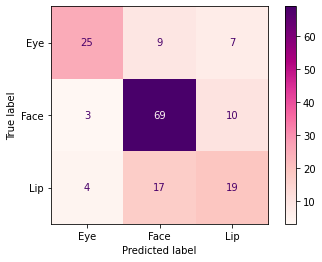

In [ ]:
matrix = confusion_matrix(y_test, y_pred, labels = gs_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels= gs_clf.classes_)
disp.plot(cmap='RdPu')